In [1]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageOps
from tqdm import tqdm
import cv2

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications.xception import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Constants
IMG_SIZE = (294, 294)
BATCH_SIZE = 32
SEED = 42
tf.random.set_seed(SEED)
np.random.seed(SEED)

print("✅ Libraries Imported & Seeds Set")

2026-02-03 16:39:45.991132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770136786.206824      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770136786.273473      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770136786.794873      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770136786.794915      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770136786.794917      24 computation_placer.cc:177] computation placer alr

✅ Libraries Imported & Seeds Set


In [2]:
INPUT_TRAIN = "/kaggle/input/deepfake-image-detection/train-20250112T065955Z-001/train"
INPUT_TEST = "/kaggle/input/deepfake-image-detection/test-20250112T065939Z-001/test"
WORKING_DIR = "/kaggle/working/deepfake_augmented" # We will save augmented data here

# Create directories
for split in ['train', 'test']:
    for label in ['real', 'fake']:
        os.makedirs(os.path.join(WORKING_DIR, split, label), exist_ok=True)

# 1. Helper: Augmentation Function
def augment_image(image):
    """Apply random flip, brightness, or rotation"""
    choice = random.randint(0, 3)
    if choice == 0: return cv2.flip(image, 1) # Horizontal Flip
    elif choice == 1: # Brightness
        hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
        hsv[:,:,2] = np.clip(hsv[:,:,2] * random.uniform(0.8, 1.2), 0, 255)
        return cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    elif choice == 2: # Rotate
        h, w = image.shape[:2]
        M = cv2.getRotationMatrix2D((w//2, h//2), random.randint(-15, 15), 1)
        return cv2.warpAffine(image, M, (w, h))
    return image # No change

# 2. Process & Copy Data
print("⚙️ Processing Data (Copying Test, Augmenting Train)...")

# Process TRAIN (With Augmentation)
for label in ['real', 'fake']:
    src_path = os.path.join(INPUT_TRAIN, label)
    dst_path = os.path.join(WORKING_DIR, 'train', label)
    
    # Config: Augment 'fake' more than 'real' to balance
    aug_count = 5 if label == 'fake' else 2
    
    for fname in tqdm(os.listdir(src_path), desc=f"Train {label}"):
        img_path = os.path.join(src_path, fname)
        try:
            img = cv2.imread(img_path)
            if img is None: continue
            
            # Save Original
            cv2.imwrite(os.path.join(dst_path, fname), img)
            
            # Create Augmentations
            name, ext = os.path.splitext(fname)
            for i in range(aug_count):
                aug_img = augment_image(img)
                cv2.imwrite(os.path.join(dst_path, f"{name}_aug_{i}{ext}"), aug_img)
        except: continue

# Process TEST (Just Copy, No Augmentation)
for label in ['real', 'fake']:
    src_path = os.path.join(INPUT_TEST, label)
    dst_path = os.path.join(WORKING_DIR, 'test', label)
    for fname in os.listdir(src_path):
        shutil.copy(os.path.join(src_path, fname), os.path.join(dst_path, fname))

print("✅ Data Preparation Complete!")

⚙️ Processing Data (Copying Test, Augmenting Train)...


Train fake: 100%|██████████| 153/153 [00:13<00:00, 11.40it/s]


✅ Data Preparation Complete!


In [3]:
# Output Directory for Final Processed Data
FINAL_DATA_DIR = "/kaggle/working/deepfake_final"

def letterbox_preprocessing(image_path, target_size=(294, 294)):
    """Pads image to square and resizes to target_size"""
    try:
        img = Image.open(image_path).convert('RGB')
        w, h = img.size
        max_dim = max(w, h)
        pad_w = (max_dim - w) // 2
        pad_h = (max_dim - h) // 2
        padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
        # Pad with black
        img_padded = ImageOps.expand(img, padding, fill=(0, 0, 0))
        return img_padded.resize(target_size, Image.Resampling.LANCZOS)
    except:
        return None

print("⚙️ Applying Letterbox Preprocessing...")
for split in ['train', 'test']:
    for label in ['real', 'fake']:
        src = os.path.join(WORKING_DIR, split, label)
        dst = os.path.join(FINAL_DATA_DIR, split, label)
        os.makedirs(dst, exist_ok=True)
        
        files = os.listdir(src)
        for fname in tqdm(files, desc=f"Processing {split}/{label}"):
            res = letterbox_preprocessing(os.path.join(src, fname))
            if res: res.save(os.path.join(dst, fname))

print("✅ Letterboxing Complete.")

⚙️ Applying Letterbox Preprocessing...


Processing test/fake:  98%|█████████▊| 381/389 [00:17<00:00, 21.80it/s]/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Processing test/fake: 100%|██████████| 389/389 [00:17<00:00, 22.03it/s]

✅ Letterboxing Complete.


In [4]:
TRAIN_DIR = os.path.join(FINAL_DATA_DIR, 'train')
TEST_DIR = os.path.join(FINAL_DATA_DIR, 'test')

# 1. Load Datasets
print("⚡ Loading Datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, validation_split=0.2, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='binary'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, validation_split=0.2, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='binary'
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE, 
    label_mode='binary', shuffle=False
)

# 2. Optimize
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 3. Calculate Class Weights
train_labels = []
for x, y in train_ds:
    train_labels.extend(y.numpy().flatten())

class_weights = compute_class_weight(
    class_weight='balanced', classes=np.unique(train_labels), y=train_labels
)
weight_dict = dict(enumerate(class_weights))
print(f"✅ Data Loaded. Class Weights: {weight_dict}")

⚡ Loading Datasets...
Found 1896 files belonging to 2 classes.
Using 1517 files for training.


I0000 00:00:1770136962.702079      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13757 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1770136962.708531      24 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13757 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Found 1896 files belonging to 2 classes.
Using 379 files for validation.
Found 499 files belonging to 2 classes.
✅ Data Loaded. Class Weights: {0: np.float64(1.01403743315508), 1: np.float64(0.9863459037711313)}


In [5]:
TRAIN_DIR = os.path.join(FINAL_DATA_DIR, 'train')
TEST_DIR = os.path.join(FINAL_DATA_DIR, 'test')

# 1. Load Datasets
print("⚡ Loading Datasets...")
train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, validation_split=0.2, subset="training", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='binary'
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR, validation_split=0.2, subset="validation", seed=SEED,
    image_size=IMG_SIZE, batch_size=BATCH_SIZE, label_mode='binary'
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR, seed=SEED, image_size=IMG_SIZE, batch_size=BATCH_SIZE, 
    label_mode='binary', shuffle=False
)

# 2. Optimize
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# 3. Calculate Class Weights
train_labels = []
for x, y in train_ds:
    train_labels.extend(y.numpy().flatten())

class_weights = compute_class_weight(
    class_weight='balanced', classes=np.unique(train_labels), y=train_labels
)
weight_dict = dict(enumerate(class_weights))
print(f"✅ Data Loaded. Class Weights: {weight_dict}")

⚡ Loading Datasets...
Found 1896 files belonging to 2 classes.
Using 1517 files for training.
Found 1896 files belonging to 2 classes.
Using 379 files for validation.
Found 499 files belonging to 2 classes.
✅ Data Loaded. Class Weights: {0: np.float64(1.01403743315508), 1: np.float64(0.9863459037711313)}


In [6]:
def build_model():
    inputs = keras.Input(shape=IMG_SIZE + (3,))
    # Xception Preprocessing (-1 to 1 scaling)
    x = layers.Lambda(preprocess_input)(inputs)
    
    base_model = Xception(weights='imagenet', include_top=False, input_shape=IMG_SIZE + (3,))
    base_model.trainable = False # Start frozen
    
    x = base_model(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    
    return keras.Model(inputs, outputs, name="Xception_Deepfake")

model = build_model()
print("✅ Model Built.")

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
✅ Model Built.


In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    keras.callbacks.ModelCheckpoint('model_phase1.keras', save_best_only=True)
]

print("🚀 Phase 1 Training (Top Layers)...")
model.fit(train_ds, epochs=8, validation_data=val_ds, callbacks=callbacks, class_weight=weight_dict)

🚀 Phase 1 Training (Top Layers)...
Epoch 1/8


I0000 00:00:1770136974.106264      77 service.cc:152] XLA service 0x7ae6f843ff90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770136974.106303      77 service.cc:160]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1770136974.106307      77 service.cc:160]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1770136975.366401      77 cuda_dnn.cc:529] Loaded cuDNN version 91002
2026-02-03 16:43:01.892980: E external/local_xla/xla/service/slow_operation_alarm.cc:73] Trying algorithm eng3{k11=2} for conv %cudnn-conv.78 = (f32[32,128,144,144]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,128,144,144]{3,2,1,0} %bitcast.10615, f32[128,1,3,3]{3,2,1,0} %bitcast.10619), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=128, custom_call_target="__cudnn$convForward", metadata={op_type="DepthwiseConv2dNative" op_name="Xception_Deepfake_1/xception_1/block2_sepconv2_1/separabl

17/48 ━━━━━━━━━━━━━━━━━━━━ 5s 185ms/step - accuracy: 0.5960 - loss: 0.8502

2026-02-03 16:43:33.722369: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-03 16:43:33.940925: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-03 16:43:34.631898: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-03 16:43:34.831935: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-03 16:43:35.516007: E external/local_xla/xla/stream_

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 656ms/step - accuracy: 0.6665 - loss: 0.7425

2026-02-03 16:44:14.915892: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-03 16:44:15.151488: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-03 16:44:15.925660: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-03 16:44:16.195203: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-03 16:44:17.242638: E external/local_xla/xla/stream_

48/48 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.6681 - loss: 0.7395 - val_accuracy: 0.8971 - val_loss: 0.4251
Epoch 2/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 259ms/step - accuracy: 0.8994 - loss: 0.2429 - val_accuracy: 0.9103 - val_loss: 0.2987
Epoch 3/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 265ms/step - accuracy: 0.9426 - loss: 0.1477 - val_accuracy: 0.9446 - val_loss: 0.2083
Epoch 4/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 270ms/step - accuracy: 0.9479 - loss: 0.1334 - val_accuracy: 0.9631 - val_loss: 0.1440
Epoch 5/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step - accuracy: 0.9722 - loss: 0.0849 - val_accuracy: 0.9631 - val_loss: 0.0954
Epoch 6/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 289ms/step - accuracy: 0.9789 - loss: 0.0617 - val_accuracy: 0.9842 - val_loss: 0.0532
Epoch 7/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 270ms/step - accuracy: 0.9878 - loss: 0.0423 - val_accuracy: 0.9763 - val_loss: 0.0576
Epoch 8/8
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - accuracy: 0.9847 - loss: 0.0383 - val_accuracy: 0.9657 - val_l

In [8]:
# Unfreeze Base Model
model.trainable = True

# Recompile with LOW Learning Rate
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5), # Very small steps
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("🚀 Phase 2 Training (Fine-Tuning)...")
history = model.fit(
    train_ds, 
    epochs=10, 
    validation_data=val_ds, 
    callbacks=callbacks, 
    class_weight=weight_dict
)
model.save('deepfake_model_final.keras')

🚀 Phase 2 Training (Fine-Tuning)...
Epoch 1/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 57s 894ms/step - accuracy: 0.9872 - loss: 0.0342 - val_accuracy: 0.9894 - val_loss: 0.0430
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 278ms/step - accuracy: 0.9855 - loss: 0.0442 - val_accuracy: 0.9894 - val_loss: 0.0367
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 291ms/step - accuracy: 0.9827 - loss: 0.0383 - val_accuracy: 0.9921 - val_loss: 0.0332
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 14s 291ms/step - accuracy: 0.9919 - loss: 0.0289 - val_accuracy: 0.9921 - val_loss: 0.0300
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 281ms/step - accuracy: 0.9901 - loss: 0.0341 - val_accuracy: 0.9921 - val_loss: 0.0284
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 12s 258ms/step - accuracy: 0.9925 - loss: 0.0240 - val_accuracy: 0.9868 - val_loss: 0.0285
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 273ms/step - accuracy: 0.9944 - loss: 0.0260 - val_accuracy: 0.9921 - val_loss: 0.0264
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 13s 274ms/step - accura

📊 Optimizing Threshold on Test Set...
15/16 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step

2026-02-03 16:49:23.628137: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-03 16:49:23.860297: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-03 16:49:24.591712: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-03 16:49:24.824964: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2026-02-03 16:49:25.696592: E external/local_xla/xla/stream_

16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step
🏆 Best Threshold Found: 0.98

Classification Report (Threshold=0.98):
              precision    recall  f1-score   support

        fake       0.92      0.80      0.86       389
        real       0.52      0.76      0.62       110

    accuracy                           0.79       499
   macro avg       0.72      0.78      0.74       499
weighted avg       0.83      0.79      0.81       499

Confusion Matrix:
[[312  77]
 [ 26  84]]


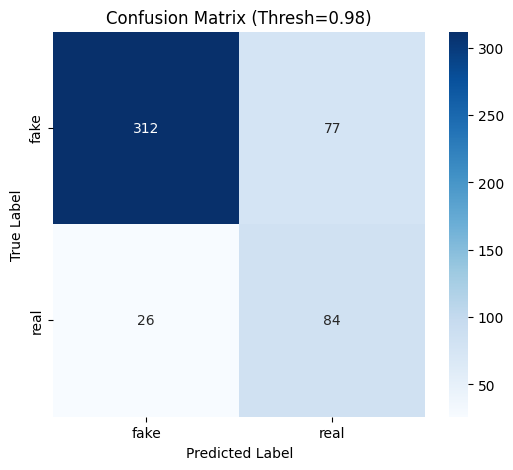

In [9]:
print("📊 Optimizing Threshold on Test Set...")

# 1. Get raw probabilities
y_pred_proba = model.predict(test_ds).flatten()
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# 2. Find Best Threshold (Maximizing F1 for Fake class)
thresholds = np.arange(0.5, 0.99, 0.01)
f1_scores = []
for t in thresholds:
    y_temp = (y_pred_proba > t).astype(int)
    # pos_label=0 because 0 is 'fake' and we want to catch fakes
    f1_scores.append(f1_score(y_true, y_temp, pos_label=0)) 

best_idx = np.argmax(f1_scores)
best_thresh = thresholds[best_idx]
print(f"🏆 Best Threshold Found: {best_thresh:.2f}")

# 3. Apply Best Threshold
y_final = (y_pred_proba > best_thresh).astype(int)
class_names = ['fake', 'real']

# 4. Show Results
print("\n" + "="*55)
print(f"Classification Report (Threshold={best_thresh:.2f}):")
print("="*55)
print(classification_report(y_true, y_final, target_names=class_names))

print("Confusion Matrix:")
cm = confusion_matrix(y_true, y_final)
print(cm)

# Plot
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix (Thresh={best_thresh:.2f})')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()